In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from matplotlib import rcParams
from sklearn.svm import SVR
from numpy import array, arange, mean, median
from numpy.linalg import norm

rcParams['font.size'] = 8

from C3SData.data import C3SD
from kmcm import KMCMulti, kmcm_p_grid

In [2]:
data = C3SD('C3S.db', seed=2345)
data.featurize()
data.train_test_split('ccs')
data.center_and_scale()


In [3]:
kmc = KMCMulti(seed=2345, n_clusters=4, estimator_params=[{'C': 16000, 'gamma': 0.001},
                                                          {'C': 8000, 'gamma': 0.001},
                                                          {'C': 16000, 'gamma': 0.0005},
                                                          {'C': 16000, 'gamma': 0.0005}], 
               use_estimator=SVR(cache_size=2048, tol=5e-4))
kmc.fit(data.X_train_ss_, data.y_train_)


KMCMulti(estimator_params=[{'C': 16000, 'gamma': 0.001},
                           {'C': 8000, 'gamma': 0.001},
                           {'C': 16000, 'gamma': 0.0005},
                           {'C': 16000, 'gamma': 0.0005}],
         n_clusters=4, seed=2345,
         use_estimator=SVR(C=1.0, cache_size=2048, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.0005,
                           verbose=False))

In [4]:
X_clusters = array([kmc.kmeans_.predict(x.reshape(1, -1))[0] for x in data.SScaler_.transform(data.X_)])

In [24]:
cluster_dists = [[], [], [], []]
cluster_dists_combined = []
for c, x in zip(X_clusters, data.SScaler_.transform(data.X_)):
    cluster_dists[c].append(norm(x - kmc.kmeans_.cluster_centers_[c]))
    cluster_dists_combined.append(norm(x - kmc.kmeans_.cluster_centers_[c]))


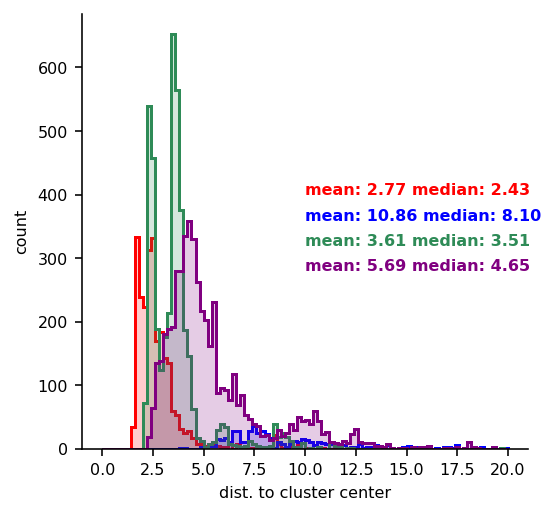

In [6]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

bins = arange(0, 20.001, 0.2)
y0 = 400
for cd, c in zip(cluster_dists, ['r', 'b', 'seagreen', 'purple']):
    plt.hist(cd, bins=bins, histtype='stepfilled', color=c, alpha=0.2)
    plt.hist(cd, bins=bins, histtype='step', color=c, lw=1.5)
    plt.text(10, y0, 'mean: {:.2f} median: {:.2f}'.format(mean(cd), median(cd)), fontweight='bold', fontsize=8, color=c)
    y0 -= 40
    
    
for d in ['top', 'right']:
    ax.spines[d].set_visible(False) 
ax.set_xlabel('dist. to cluster center')
ax.set_ylabel('count')

plt.savefig('cluster_distance_distributions.png', dpi=400, bbox_inches='tight')
plt.show()
plt.close()

In [7]:
dmat = [[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]]
for i in range(4):
    for j in range(4):
        dmat[i][j] = norm(kmc.kmeans_.cluster_centers_[i] - kmc.kmeans_.cluster_centers_[j])
print('     c0   c1   c2  c3')
print('c0 {:.2f} {:.2f} {:.2f} {:.2f}'.format(dmat[0][0], dmat[0][1], dmat[0][2], dmat[0][3]))
print('c1       {:.2f} {:.2f} {:.2f}'.format(dmat[1][1], dmat[1][2], dmat[1][3]))
print('c2            {:.2f} {:.2f}'.format(dmat[2][2], dmat[2][3]))
print('c3                 {:.2f}'.format(dmat[3][3]))

     c0   c1   c2  c3
c0 0.00 10.68 4.20 7.06
c1       0.00 9.81 9.98
c2            0.00 6.14
c3                 0.00


In [8]:
from rdkit import DataStructs
from rdkit import Chem

In [17]:
fps = [Chem.RDKFingerprint(Chem.MolFromSmiles(smi), fpSize=1024) for smi in data.smi_]

In [18]:
fps[0].ToBitString()


'111101001011000010000000011000000000101010000000000100010010110010010110000000100100110000010101001000011101011000100000101110110101000000010000100010100000001011000101000000100000000000000100111000000000100000000010001010000100000010110001000001001000111000001111000000000000010010100100000000100110000001000100001000000100001001100000000000011100001001010100100100000000010010000100001100100010001100000000000111000011010000000100000000000110000000110100000000110100001010000100100000000000000000100001000000000100000101000100010010100000000000000000010000000100111000000000000111000001000000000000100000101000000000000100100000011100000110001000000000110011100100000011001000000001100000000000001000010000000100000000000001000100100011000110100100100000000011100000001000001000001000010010100001010010000000011000000000001010100000001110011110101011101101000001001000001000000000010101001010100000011000101000100000000010000001100101100000000000010001000000000000000000000101001000001000010001010

In [19]:
def n_best_tc_score(fp_1, fp_all, n):
    """ computes Tanimoto coefficients for a fingerprint against all training data fingerprints then 
        averages together the best N coefficients for the final score """
    tcoefs = [DataStructs.FingerprintSimilarity(fp_1, fp) for fp in fp_all]
    return mean(sorted(tcoefs, reverse=True)[:n])    
    

In [22]:
n_best_tc_score(fps[0], fps, 5)

0.8258064516129033

In [32]:
from sklearn.linear_model import LinearRegression as LR

In [23]:
tc_best_5 = [n_best_tc_score(fp, fps, 5) for fp in fps]

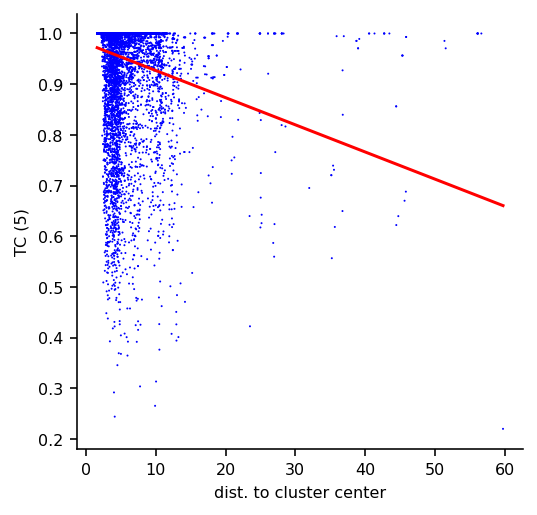

In [39]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)


lr = LR().fit(array(cluster_dists_combined).reshape(-1, 1), tc_best_5)
x = [min(cluster_dists_combined), max(cluster_dists_combined)]
y = lr.predict(array(x).reshape(-1, 1))
ax.scatter(cluster_dists_combined, tc_best_5, color='b', marker='o', s=1, edgecolor='none')
ax.plot(x, y, 'r-', lw=1.5)

    
for d in ['top', 'right']:
    ax.spines[d].set_visible(False) 
ax.set_xlabel('dist. to cluster center')
ax.set_ylabel('TC (5)')

plt.show()
plt.close()

In [28]:
tc_best_10 = [n_best_tc_score(fp, fps, 10) for fp in fps]

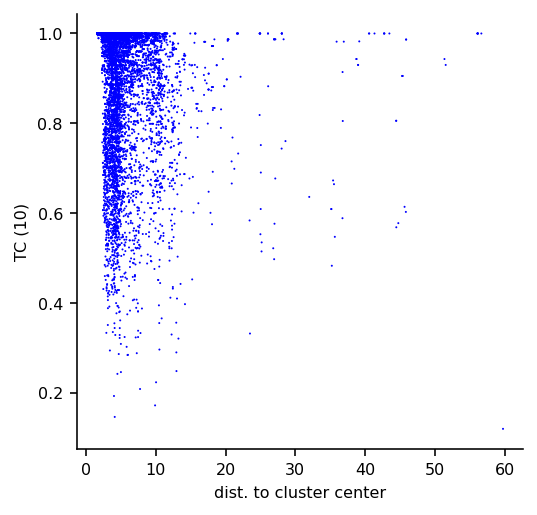

In [29]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

ax.scatter(cluster_dists_combined, tc_best_10, color='b', marker='o', s=1, edgecolor='none')
    
    
for d in ['top', 'right']:
    ax.spines[d].set_visible(False) 
ax.set_xlabel('dist. to cluster center')
ax.set_ylabel('TC (10)')

plt.show()
plt.close()

In [30]:
tc_best_20 = [n_best_tc_score(fp, fps, 20) for fp in fps]

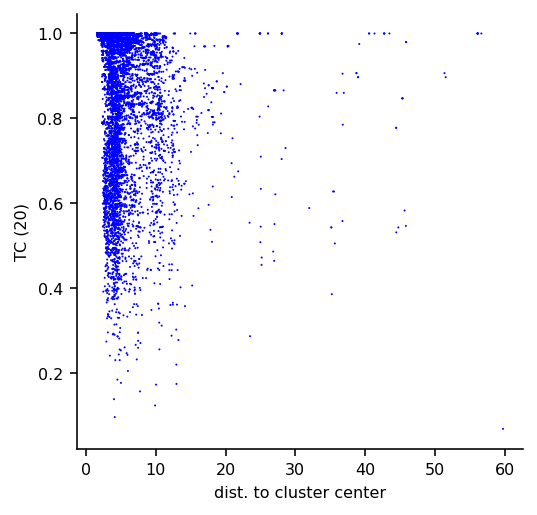

In [31]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)

ax.scatter(cluster_dists_combined, tc_best_20, color='b', marker='o', s=1, edgecolor='none')
    
    
for d in ['top', 'right']:
    ax.spines[d].set_visible(False) 
ax.set_xlabel('dist. to cluster center')
ax.set_ylabel('TC (20)')

plt.show()
plt.close()